# Gambler's Problem - Value Iteration Solution


This code solves the Gambler's Problem using dynamic programming (value iteration).

**Problem Description:**
A gambler bets on coin flips. On each flip:
- With probability ph: the gambler wins the amount staked
- With probability (1-ph): the gambler loses the amount staked

The gambler's goal is to reach a target amount (e.g., $100) starting from some initial capital.
The gambler can stake any amount up to their current capital (but not more than needed to reach the target).

**Approach:**
We use value iteration to compute the optimal value function and policy.


In [1]:
import matplotlib.pyplot as plt
import random

# Enable inline plotting
%matplotlib inline

### INITIALIZATION


In [2]:
def init(target_amount=100):
    """
    Initialize the problem state, value function, and reward function.
    
    Parameters:
    -----------
    target_amount : int
        The target amount of money to reach (goal state)
    
    Returns:
    --------
    state : list
        List of all non-terminal states (1 to target_amount-1)
    value : list
        Initial value function (all zeros except terminal states)
    reward : list
        Reward function (1 for reaching target, 0 otherwise)
    """
    state = list(range(1, target_amount))
    value = [0] * target_amount + [0]
    reward = [0] * target_amount + [1]
    return state, value, reward

In [3]:
def argmax(arr, resolve_clash='first'):
    """
    Find the index of the maximum value in an array.
    
    Parameters:
    -----------
    arr : list
        Input array
    resolve_clash : str
        How to resolve ties in case of multiple maximum values
        Options: 'random', 'first', 'last' (default: 'first')
    
    Returns:
    --------
    int : Index of the maximum value
    """
    assert len(arr) > 0, "argmax requires a non-empty list"
    
    max_ind = []
    max_val = -1e32
    
    for i, val in enumerate(arr):
        if max_val < val:
            max_ind = [i]
            max_val = val
        elif max_val == val:
            max_ind.append(i)
    
    if resolve_clash == 'random':
        return max_ind[random.randint(0, len(max_ind) - 1)]
    elif resolve_clash == 'last':
        return max_ind[-1]
    return max_ind[0]

### VALUE ITERATION CORE FUNCTIONS


In [4]:
def one_step_forward(s, value, reward, gamma, ph, actions):
    """
    Calculate the expected value for each possible action from state s.
    
    This implements the Bellman equation for the action-value function.
    
    Parameters:
    -----------
    s : int
        Current state (current capital)
    value : list
        Current value function
    reward : list
        Reward function
    gamma : float
        Discount factor
    ph : float
        Probability of winning a coin flip
    actions : list
        List of possible actions (bet amounts)
    
    Returns:
    --------
    list : Expected values for each action
    """
    v = [0] * len(value)
    
    for a in actions:
        # Expected value = ph * (win outcome) + (1-ph) * (lose outcome)
        v[a] = ph * (reward[s + a] + gamma * value[s + a]) + \
               (1 - ph) * (reward[s - a] + gamma * value[s - a])
    
    return v

In [5]:
def run(state, value, reward, target_amount=100, ph=0.4, theta=1e-20, gamma=0.99):
    """
    Run the value iteration algorithm to convergence.
    
    Iteratively updates the value function for all states until the maximum
    change in any state value is less than theta (convergence threshold).
    
    Parameters:
    -----------
    state : list
        List of all non-terminal states
    value : list
        Initial value function
    reward : list
        Reward function
    target_amount : int
        Target capital to reach
    ph : float
        Probability of winning (coin flip heads)
    theta : float
        Convergence threshold
    gamma : float
        Discount factor
    
    Returns:
    --------
    value : list
        Converged value function
    sweeps : int
        Number of sweeps (iterations) until convergence
    values : list
        History of value functions at each sweep
    """
    sweeps = 0
    values = []
    
    while True:
        sweeps += 1
        delta = 0.0
        
        # Update value for each state
        for s in state:
            v = value[s]
            
            # Possible actions: bet 1 to min(current capital, amount needed to reach target)
            actions = list(range(1, 1 + min(s, target_amount - s)))
            
            # Calculate expected values for all actions
            action_vals = one_step_forward(s, value, reward, gamma, ph, actions)
            
            # Update value to the maximum expected value
            value[s] = max(action_vals)
            
            # Track maximum change
            delta = max(delta, abs(value[s] - v))
        
        # Store value function history
        values.append(value[:])
        
        # Check for convergence
        if delta < theta:
            break
    
    return value, sweeps, values


In [6]:
def get_optimal_policy(state, value, reward, target_amount=100, ph=0.4, gamma=1, resolve_clash='first'):
    """
    Extract the optimal policy from the value function.
    
    For each state, selects the action (bet amount) that maximizes expected value.
    
    Parameters:
    -----------
    state : list
        List of all non-terminal states
    value : list
        Converged value function
    reward : list
        Reward function
    target_amount : int
        Target capital to reach
    ph : float
        Probability of winning
    gamma : float
        Discount factor
    resolve_clash : str
        How to resolve ties when multiple actions have the same value
    
    Returns:
    --------
    list : Optimal policy (best action for each state)
    """
    pi = [0] * target_amount
    
    for s in state:
        # Possible actions for this state
        actions = list(range(1, 1 + min(s, target_amount - s)))
        
        # Calculate expected values for all actions
        action_vals = one_step_forward(s, value, reward, gamma, ph, actions)
        
        # Select the action with highest expected value
        pi[s] = argmax(action_vals, resolve_clash=resolve_clash)
    
    return pi

### MAIN SOLVER

In [7]:
def solve(target_amount=100, ph=0.4, theta=1e-20, gamma=1, resolve_clash='first'):
    """
    Complete solution for the Gambler's Problem.
    
    Combines initialization, value iteration, and policy extraction to solve
    the problem and return the optimal policy.
    
    Parameters:
    -----------
    target_amount : int
        Target capital to reach (goal)
    ph : float
        Probability of winning each coin flip
    theta : float
        Convergence threshold for value iteration
    gamma : float
        Discount factor (typically 1 for episodic tasks)
    resolve_clash : str
        How to resolve ties in policy extraction
    
    Returns:
    --------
    pi : list
        Optimal policy (best bet for each capital level)
    value : list
        Final value function
    values : list
        History of value functions during iteration
    sweeps : int
        Number of iterations until convergence
    """
    # Initialize
    state, value, reward = init(target_amount=target_amount)

    # Run value iteration algorithm
    value, sweeps, values = run(state, value, reward,
                                 target_amount=target_amount,
                                 ph=ph, theta=theta, gamma=gamma)

    # Extract optimal policy
    pi = get_optimal_policy(state, value, reward,
                            target_amount=target_amount,
                            ph=ph, gamma=gamma,
                            resolve_clash=resolve_clash)
    
    return pi, value, values, sweeps


### SOLVE THE PROBLEM

In [8]:
# Problem parameters
target_amount = 100
ph = 0.4              # Probability of winning (unfavorable odds)
theta = 1e-50         # Very small convergence threshold
gamma = 1.00          # No discounting (episodic task)
resolve_clash = 'first'

# Solve
pi, value, values, sweeps = solve(target_amount=target_amount, 
                                   ph=ph, 
                                   theta=theta, 
                                   gamma=gamma, 
                                   resolve_clash=resolve_clash)

print(f"Converged after {sweeps} sweeps")

Converged after 33 sweeps


### VISUALIZATION 1: VALUE FUNCTION CONVERGENCE

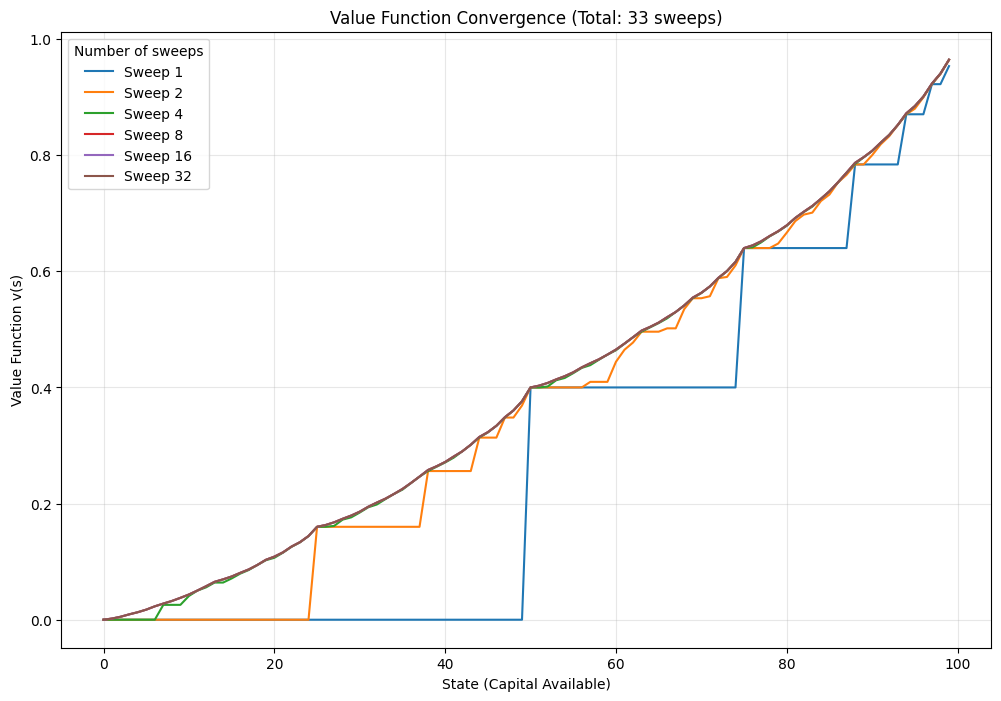

In [9]:
plt.figure(figsize=(12, 8))

# Plot value function at exponentially spaced sweeps
leg = []
i = 1
while i < len(values):
    leg.append(f'Sweep {i}')
    plt.plot(values[i-1][:-1])
    i *= 2

plt.legend(leg, title='Number of sweeps')
plt.xlabel("State (Capital Available)")
plt.ylabel("Value Function v(s)")
plt.title(f"Value Function Convergence (Total: {sweeps} sweeps)")
plt.grid(True, alpha=0.3)
plt.show()

### VISUALIZATION 2: OPTIMAL POLICY

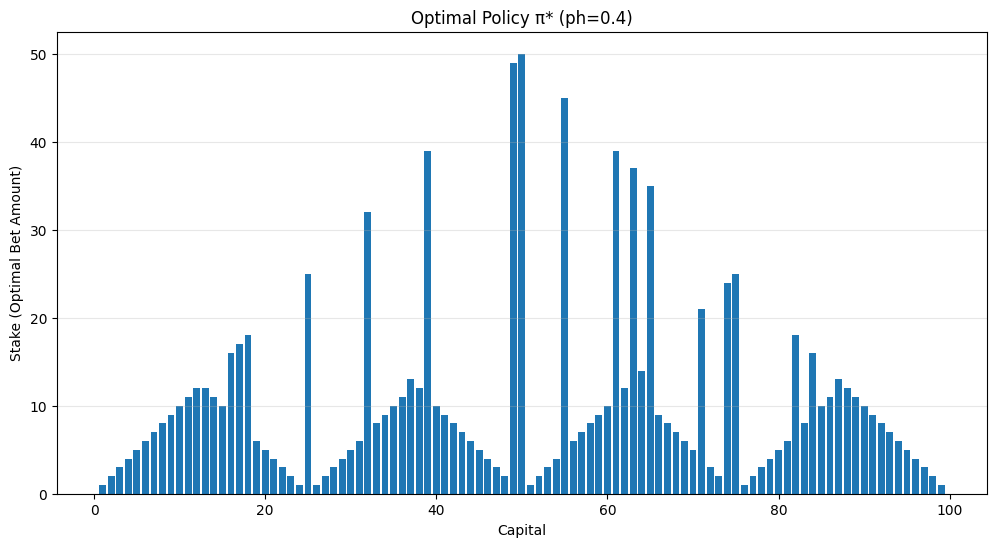


Key Insights:
- With probability ph=0.4 (unfavorable odds), the optimal strategy
  shows interesting patterns in betting behavior
- The policy converges to making specific strategic bets at different capital levels


In [10]:
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(pi)), pi[1:])
plt.xlabel('Capital')
plt.ylabel('Stake (Optimal Bet Amount)')
plt.title(f'Optimal Policy π* (ph={ph})')
plt.grid(True, alpha=0.3, axis='y')
plt.show()

print("\nKey Insights:")
print(f"- With probability ph={ph} (unfavorable odds), the optimal strategy")
print(f"  shows interesting patterns in betting behavior")
print(f"- The policy converges to making specific strategic bets at different capital levels")